In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [3]:
import time;
start = time.time()
!unzip -q 'gdrive/My Drive/Pull-0-Depth/MonoDepth_Inp_Dataset_192.zip' -d 'Data/'
print (time.time() - start)

232.7224521636963


In [4]:
import time;

start = time.time()
!unzip -q 'gdrive/My Drive/Pull-0-Depth/MonoDepth_GT_Dataset_192.zip' -d 'Data/Dataset/depth_'
print (time.time() - start)

75.80247640609741


In [5]:
import time;

start = time.time()
!unzip -q 'gdrive/My Drive/Pull-0-Depth/bg_192.zip' -d 'Data/Dataset/bg_'
print (time.time() - start)

8.838196039199829


In [6]:
import os

list_m = os.listdir('Data/Dataset/mask_/mask') # dir is your directory path
list_f = os.listdir('Data/Dataset/fg_bg_/fg_bg') # dir is your directory path
list_d = os.listdir('Data/Dataset/depth_/depth') # dir is your directory path
list_b_temp = os.listdir('Data/Dataset/bg_/bg_192') # dir is your directory path

list_f.sort()
list_m.sort()
list_d.sort()
list_b_temp.sort()

list_b = []
for bg in list_b_temp:
    list_b += [bg]*4000

print('No. of fg_bg Images: ', len(list_f))
print('No. of mask Images: ', len(list_m))
print('No. of depth Images: ', len(list_d))
print('No. of backround Images: ', len(list_b))

No. of fg_bg Images:  400000
No. of mask Images:  400000
No. of depth Images:  400000
No. of backround Images:  400000


In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import time

In [9]:
# Shuffling the Dataset
import random

for _ in range(50):
    seed = random.random()
    def rand_num():
        return seed
    random.shuffle(list_f, rand_num)
    random.shuffle(list_b, rand_num)

#Testing if Randomizing worked
print(list_f[351275])
print(list_b[351275])

bg192_48_fg1617.jpg
bg192_48.jpg


In [11]:
#Creating Split of Data for Training and Testing of 70:30
train_split = int(len(list_f)*0.6)
train_data = list_f[0:train_split]
test_data = list_f[train_split:]
print(len(train_data), len(test_data))

240000 160000


In [12]:
from Data import DepMaskDataset
train_dataset = DepMaskDataset(train_data)
test_dataset = DepMaskDataset(test_data)

In [14]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [15]:
data = next(iter(train_loader))
print(type(data))
print(len(data))

<class 'dict'>
4


In [16]:
print(len(train_loader)) # Number of Train Batches
print(len(test_loader)) # Number of Test Batches 

7500
5000


In [17]:
print('Number of fg_bg Images in one batch: ', data['fgbg'].shape)
print('Number of bg Images in one batch: ', data['bg'].shape)
print('Number of mask Images in one batch: ', data['mask'].shape)
print('Number of depth Images in one batch: ', data['depth'].shape)

Number of fg_bg Images in one batch:  torch.Size([32, 3, 192, 192])
Number of bg Images in one batch:  torch.Size([32, 3, 192, 192])
Number of mask Images in one batch:  torch.Size([32, 1, 192, 192])
Number of depth Images in one batch:  torch.Size([32, 1, 192, 192])


In [18]:
from UNet import UNet
from loss import BCEDiceLoss, RMSELoss, rmse, miou
import torch.optim as optim
from tqdm import tqdm
import gc

In [19]:
model = UNet(6).to('cuda')
optimizer = optim.Adam(model.parameters())

In [20]:
checkpoint = torch.load('/content/gdrive/My Drive/Pull-0-Depth/model_weights/weights_ep5.pth') #Contunuing From 5th Epoch
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [21]:
from torchsummary import summary
summary(model, (6,192,192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 192, 192]           3,456
       BatchNorm2d-2         [-1, 64, 192, 192]             128
              ReLU-3         [-1, 64, 192, 192]               0
            Conv2d-4         [-1, 64, 192, 192]          36,864
       BatchNorm2d-5         [-1, 64, 192, 192]             128
              ReLU-6         [-1, 64, 192, 192]               0
        DoubleConv-7  [[-1, 64, 192, 192], [-1, 64, 192, 192]]               0
         MaxPool2d-8           [-1, 64, 96, 96]               0
            Conv2d-9          [-1, 128, 96, 96]          73,728
      BatchNorm2d-10          [-1, 128, 96, 96]             256
             ReLU-11          [-1, 128, 96, 96]               0
           Conv2d-12          [-1, 128, 96, 96]         147,456
      BatchNorm2d-13          [-1, 128, 96, 96]             256
             ReLU-14    

In [22]:
from train import train
from test import test

In [25]:
start_process = time.time()
for i in range(5,6):
    epoch_time = time.time()
    train(train_loader, model, optimizer)
    print(f'********* EPOCH {i+1} TIME: {time.time()-epoch_time} seconds')
    print('******************************************************************************************************************')
torch.cuda.empty_cache()
fgbg, bg, mask_gt, depth_gt, mask_pred, depth_pred = test(test_loader, model, optimizer)
print('Total Time: ', time.time() - start_process)

100%|██████████| 7500/7500 [1:02:50<00:00,  1.99it/s]



Load Time:  3562.179646253586
Prediciton Time:  49.67711567878723
Loss Time:  9.54039978981018
Backprop Time:  85.68926692008972
Total Time for One Batch:  3770.038351535797
********************* LOSSES ****************************
Segmentation Loss:  1.096484899520874
Depth Loss:  0.06728530675172806
Total Loss:  1.163769245147705
mean IOU:  0.2723722755908966
mean RMSE:  0.06728530675172806
********************* ****** ****************************


  0%|          | 0/5000 [00:00<?, ?it/s]

********* EPOCH 6 TIME: 3770.868782043457 seconds
******************************************************************************************************************


100%|██████████| 5000/5000 [13:46<00:00,  6.05it/s]


Load Time:  745.6477015018463
Prediciton Time:  28.067389011383057
Loss Time:  5.82808780670166
Total Time for One Batch:  826.9126017093658
********************* LOSSES ****************************
Segmentation Loss:  1.0965081453323364
Depth Loss:  0.06509178876876831
Total Loss:  1.1616002321243286
mean IOU:  0.27215179800987244
mean RMSE:  0.06509178876876831
********************* ****** ****************************
Total Time:  4598.00307559967


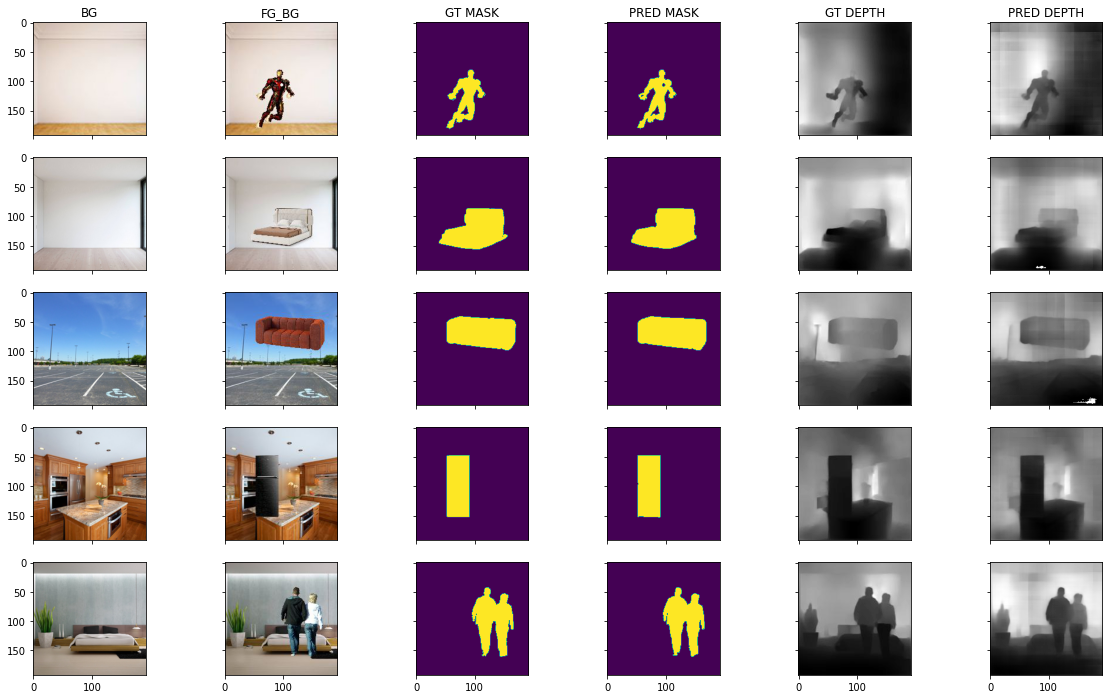

In [40]:
from plot import plot
plot(fgbg, bg, mask_gt, mask_pred, depth_gt, depth_pred)

In [34]:
torch.save({
            'epoch': 6,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, '/content/gdrive/My Drive/Pull-0-Depth/weights_ep6.pth')